### OOI data set processing and analysis
Read in the matlab data files from Jim Edson and perfome some cleaning. 

CLIMODE and SouthernOcean have only a single file, but Endurance, Irminger, and Pioneer have multiple files.

We pick a subset of varibles. See `ooi_helper.py` for details. There are only wind stress (UW) and sonic temperature fluxes (WT) but no direct eddy covariance for humidity fluxes.


In [ ]:
import scipy.io
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
path = f'/scratch/jw8736/mlflux/data/OOI/'

%load_ext autoreload
%autoreload 3

In [3]:
# ds.to_netcdf('output.nc')
ref = '/scratch/jw8736/mlflux/data/Processed/psd_coare3p6_weight1_wave0.nc'
ds_ref = xr.load_dataset(ref)

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


### Data loading

In [ ]:
### Right now we name the new dimension "dim" which is a bit generic
from ooi_helper import convert_mat_to_xarray, clean

In [20]:
ds_ooi = []
filenames = ['Transfer_SouthernOcean_2_v3.mat', 'Transfer_CLIMODE_v3.mat', 'Transfer_Irminger_10_v3.mat',
             'Transfer_Endurance_9_v3.mat', 'Transfer_Pioneer_10_v3.mat']
for filename in filenames:
    mat_data = scipy.io.loadmat(path + filename, struct_as_record=False, squeeze_me=True)
    ds = convert_mat_to_xarray(mat_data)
    ds = clean(ds)
    ds_ooi.append(ds)

In [46]:
### We can also load some cruises
import glob
campaign_name = 'SouthernOcean' # or Endurance or Pioneer or CLIMODE or SouthernOcean
files = sorted(glob.glob(path + f'Transfer_{campaign_name}_*.mat'))
ds_campaign = []
for filename in files:
    mat_data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    ds = convert_mat_to_xarray(mat_data)
    ds = clean(ds)
    ds_campaign.append(ds)
    
### Concatenate along dim dimension
ds_campaign = xr.concat(ds_campaign, dim='dim')
ds_campaign.to_netcdf(f'/scratch/jw8736/mlflux/data/OOI/Transfer_{campaign_name}_all.nc')

In [ ]:
### Example of converting yday to datetime
# from datetime import datetime, timedelta
# import numpy as np
# year = 2023
# doy = 123.5
# base_date = datetime(year, 1, 1)
# datetimes = np.array([base_date + timedelta(days=float(d) - 1) for d in ds_campaign.yday])
# datetimes[-1]

datetime.datetime(2023, 12, 13, 7, 11, 0, 9493)

### Check ANN trained on PSD applied to buoy data from OOI
Without height dependence there are some issues.

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


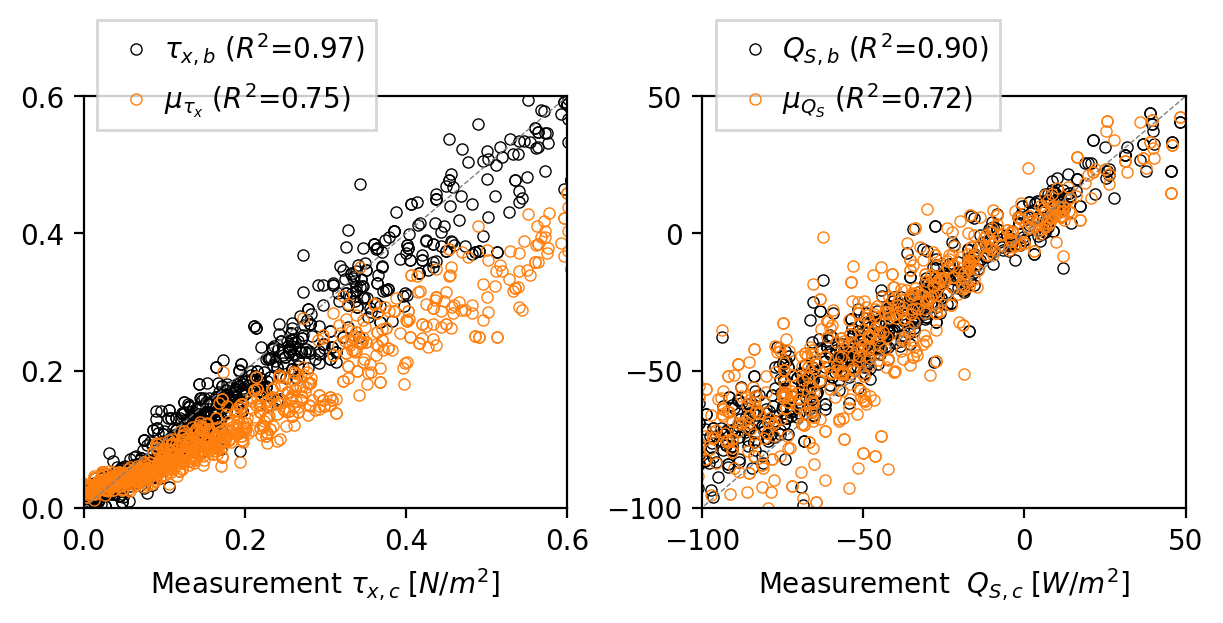

In [25]:
from mlflux.eval import open_case, plot_corr, evaluate

LH_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
SH_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
M_dir  = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
rand_seed = 4 # choose the one random seed where loss curves look good

fig, axes = plt.subplots(1, 2, figsize=[6,3], dpi=200, constrained_layout=True)

ds = ds_ooi[4]
model_M = open_case (M_dir, 'model_rand%g.p' %rand_seed)
plot_corr (axes[0], model_M, ds, subsample=1000)

model_SH = open_case (SH_dir, 'model_rand%g.p' %rand_seed)
plot_corr (axes[1], model_SH, ds, subsample=1000)

# There is no latent heat flux in the OOI data
# model_LH = open_case (LH_dir, 'model_rand%g.p' %rand_seed)
# plot_corr (axes[2], model_LH, ds, subsample=1000)

In [35]:
model = model_SH
ds = ds_ooi[4]
# scores: ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2
scores = evaluate (model, ds, WEIGHT=False)
print('R2 full dataset: ANN - %.3f, bulk - %.3f' %(scores[1][0], scores[6][0]))
print('RMSE full dataset: ANN - %.3f, bulk - %.3f' %(scores[0][0]**0.5, scores[5][0]**0.5))

R2 full dataset: ANN - 0.723, bulk - 0.904
RMSE full dataset: ANN - 43.914, bulk - 25.830


In [ ]:
total_params = sum(p.numel() for p in model_LH.mean_func.parameters())
print(f"Total number of parameters: {total_params}")

### Visualizing OOI site location

In [57]:
ds_ooi = []
filenames = ['Transfer_SouthernOcean_2_v3.mat', 'Transfer_CLIMODE_v3.mat', 'Transfer_Irminger_10_v3.mat',
             'Transfer_Endurance_9_v3.mat', 'Transfer_Pioneer_10_v3.mat']
for filename in filenames:
    mat_data = scipy.io.loadmat(path + filename, struct_as_record=False, squeeze_me=True)
    ds = convert_mat_to_xarray(mat_data)
    ds_ooi.append(ds)

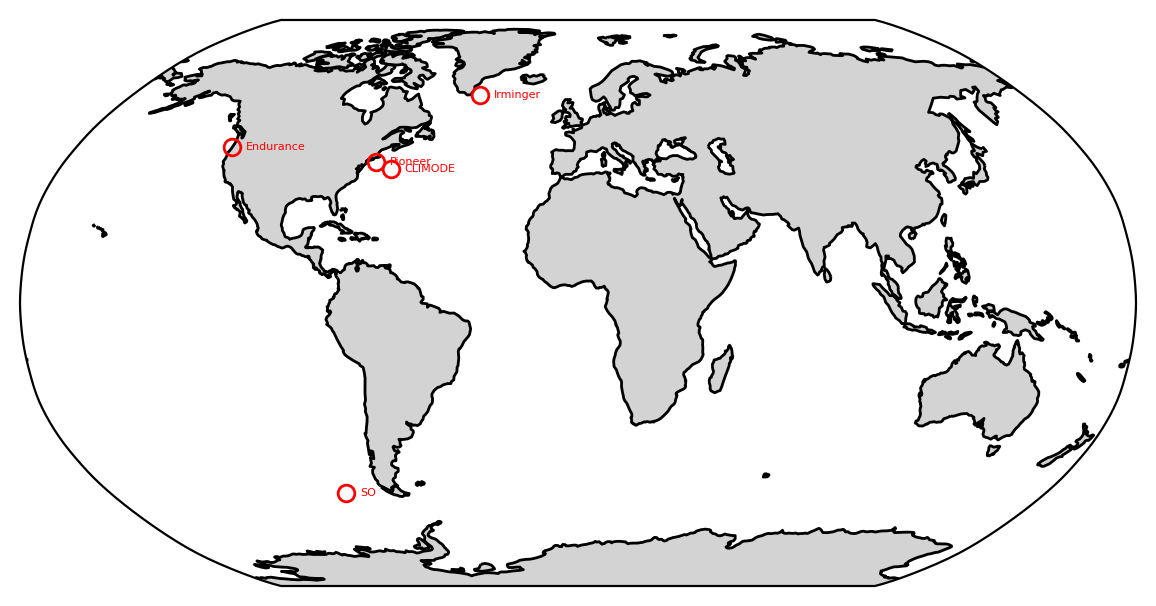

In [69]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

pcodes = {'77':'Metz', '67':'Calwater', '72':'HiWInGS', '78':'NEAQS', '73':'Capricorn', '71':'GasEx', 
          '69':'EPIC', '87':'WHOTS', '83':'Stratus', '68':'DYNAMO'}

pcode_ordered = [77, 67, 72, 78, 73, 71, 68, 83, 69, 87]

fig = plt.figure(figsize=(8,5), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
# ax.stock_img()
# ax.add_feature(cfeature.LAND, color='gainsboro')  # Dry land in tan color
ax.add_feature(cfeature.LAND, color='lightgray')  # Dry land in tan color
# ax.add_feature(cfeature.LAND, color='linen')  # Dry land in tan color
ax.coastlines()
colors = cm.tab10(np.linspace(0, 1, 10))

# lines = []
# labels = []
# for i, p in enumerate(pcode_ordered):
#     idx = ds_ref.pcode == p
#     pcode = pcodes[str(int(p))]
#     line = ax.scatter(ds_ref.lon[idx], ds_ref.lat[idx],
#                     s=1, color=colors[i], label='{}'.format(pcode), transform=ccrs.PlateCarree())
#     lines.append(line)
#     labels.append('{}'.format(pcode))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

campaigns = ['SO', 'CLIMODE', 'Irminger', 'Endurance', 'Pioneer']
for i, ds in enumerate(ds_ooi):
    line = ax.plot(ds.lon, ds.lat, marker='o', markerfacecolor='none',
                   markersize=6, color='red', transform=ccrs.PlateCarree())
    ax.annotate(campaigns[i], xy=(ds.lon.values, ds.lat.values), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                textcoords="offset points", xytext=(5, 0), ha='left', va='center', fontsize=4, color='red')

# First row with 3 items
# legend1 = ax.legend(handles=lines[:1], labels=labels[:1], loc='upper left',
#                     bbox_to_anchor=(0.1, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)
# legend2 = ax.legend(handles=lines[1:4], labels=labels[1:4], loc='upper left',
#                     bbox_to_anchor=(0.3, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)
# legend3 = ax.legend(handles=lines[4:6], labels=labels[4:6], loc='upper left',
#                     bbox_to_anchor=(0.5, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)
# legend4 = ax.legend(handles=lines[6:10], labels=labels[6:10], loc='upper left',
#                     bbox_to_anchor=(0.7, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)

# # leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, ncol=2, fontsize=10)

# ax.add_artist(legend1)
# ax.add_artist(legend2)
# ax.add_artist(legend3)

# for leg in (legend1, legend2, legend3, legend4):
#     for handle in leg.legendHandles:
#         handle.set_sizes([25])

### Visualize distribution difference

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


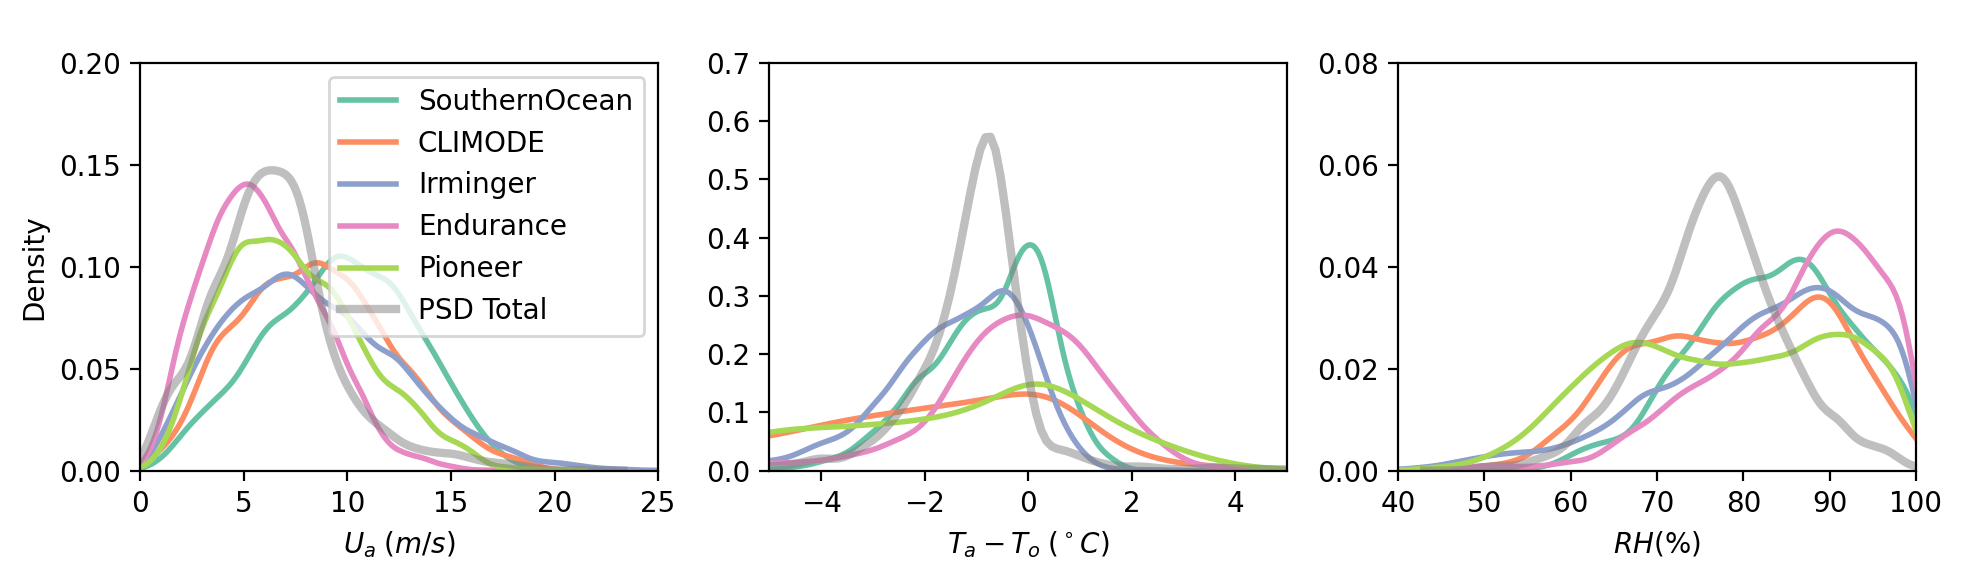

In [73]:
import warnings
# Suppress only the specific FutureWarning
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*use_inf_as_na.*"
)
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=[10,3], dpi=200)

campaigns = ['SouthernOcean', 'CLIMODE', 'Irminger', 'Endurance', 'Pioneer']
for i, ca in enumerate(campaigns):
    ds_ooi = xr.open_dataset(f'/scratch/jw8736/mlflux/data/OOI/Transfer_{ca}_all.nc')
    sns.kdeplot(ds_ooi.U, ax=axes[0], label=ca, c=plt.get_cmap('Set2')(i), lw=2)
    sns.kdeplot(ds_ooi.tair - ds_ooi.tsea, ax=axes[1], label=ca, c=plt.get_cmap('Set2')(i), lw=2)
    sns.kdeplot(ds_ooi.rh, ax=axes[2], label=ca, c=plt.get_cmap('Set2')(i), lw=2)

ds = xr.load_dataset('../../data/Processed/psd_coare3p0_weight0_wave0.nc')
sns.kdeplot(ds.U, ax=axes[0], label='PSD Total', c='gray', lw=3, alpha=0.5)
sns.kdeplot(ds.tair-ds.tsea, ax=axes[1], label='PSD Total', c='gray', lw=3, alpha=0.5)
sns.kdeplot(ds.rh, ax=axes[2], label='PSD Total', c='gray', lw=3, alpha=0.5)

# labels = ['Metz', 'N. Pac./Atl.', 'SO', 'Tropics']
# split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]] # metz
# split2 = [[77, 69, 87, 83, 68, 73, 71], [67, 72, 78], [67, 72, 78]] # calwater, hiwings, neaqs
# split3 = [[77, 69, 83, 87, 68, 67, 72, 78], [73, 71], [73, 71]] # capricorn, gasex
# split4 = [[77, 67, 72, 73, 78, 71], [68, 83, 69, 87], [68, 83, 69, 87]] # dynamo, stratus, epic, whots
# split_ensem = [split1, split2, split3, split4]

# from mlflux.datafunc import data_split_psd
# for i in range(len(split_ensem)):
#     training_ds, validating_ds, testing_ds = data_split_psd(ds, split=split_ensem[i], 
#                                                             PLOT=False, XVIS='samples', VERBOSE=False)
#     snumber = len(testing_ds.U.values)
#     print (snumber)
#     sns.kdeplot(testing_ds.U, ax=axes[0], label=labels[i], c=plt.get_cmap('Set2')(i))
#     sns.kdeplot(testing_ds.tair-testing_ds.tsea, ax=axes[1], label=labels[i], c=plt.get_cmap('Set2')(i))
#     sns.kdeplot(testing_ds.rh, ax=axes[2], label=labels[i], c=plt.get_cmap('Set2')(i))

axes[0].set_xlabel(r'$U_a \; (m/s)$'); axes[0].legend()
axes[0].set_title(' '); axes[0].set_xlim([0,25]); axes[0].set_ylim([0,0.2])
axes[1].set_xlabel(r'$T_a - T_o \; (^\circ C)$'); axes[1].set_ylabel('')
axes[1].set_title(' '); axes[1].set_xlim([-5,5]); axes[1].set_ylim([0,0.7])
axes[2].set_xlabel(r'$RH (\%)$'); axes[2].set_ylabel('')
axes[2].set_title(' '); axes[2].set_xlim([40,100]); axes[2].set_ylim([0,0.08])

plt.tight_layout()